In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# helper for safe reading (sample)
SAMPLE_PATH = "../data/eda_clean_sample.csv"

In [5]:
df = pd.read_csv(SAMPLE_PATH, parse_dates=['TransactionMonth','VehicleIntroDate'], low_memory=False)

# create indicators & metrics
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
df['ClaimSeverity'] = df.loc[df['HasClaim']==1, 'TotalClaims']  # NaN for no-claim rows
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

df[['HasClaim','ClaimSeverity','Margin']].describe()
df['HasClaim'].mean()  # overall claim frequency


np.float64(0.002787726802773328)

In [6]:
# group sizes
print(df['Province'].value_counts().head(10))
print(df['PostalCode'].value_counts().head(10))
print(df['Gender'].value_counts())

# check normality for severity/margin for a group (example)
group = df.loc[df['HasClaim']==1, 'TotalClaims'].dropna()
print("Shapiro p-value (small samples only):", stats.shapiro(group.sample(5000) if len(group)>5000 else group)[1])
# check skew
print("skewness severity:", group.skew())


Province
Gauteng          393865
Western Cape     170796
KwaZulu-Natal    169781
North West       143287
Mpumalanga        52718
Eastern Cape      30336
Limpopo           24836
Free State         8099
Northern Cape      6380
Name: count, dtype: int64
PostalCode
2000    133498
122      49171
7784     28585
299      25546
7405     18518
458      13775
8000     11794
2196     11048
470      10226
7100     10161
Name: count, dtype: int64
Gender
Not specified    940990
Male              42817
Female             6755
Name: count, dtype: int64
Shapiro p-value (small samples only): 6.927420376942042e-63
skewness severity: 3.8472428427709167


In [7]:
cont = pd.crosstab(df['Province'], df['HasClaim'])
cont.head()

chi2, p, dof, ex = stats.chi2_contingency(cont)
print("Chi2:", chi2, "p-value:", p, "dof:", dof)

Chi2: 104.19088107029361 p-value: 5.925510718204678e-19 dof: 8


In [8]:
groups = [grp['TotalClaims'].dropna().values for _, grp in df.groupby('Province') if grp['TotalClaims'].dropna().size>10]
h_stat, p = stats.kruskal(*groups)
print("Kruskal H:", h_stat, "p-value:", p)


Kruskal H: 104.26320595257819 p-value: 5.726734776605144e-19


In [9]:
top_postals = df['PostalCode'].value_counts().nlargest(20).index
sub = df[df['PostalCode'].isin(top_postals)]
cont = pd.crosstab(sub['PostalCode'], sub['HasClaim'])
chi2, p, dof, ex = stats.chi2_contingency(cont)
print("Chi2 (top 20 postal codes):", chi2, "p:", p)


Chi2 (top 20 postal codes): 107.20483669690398 p: 2.6030421728100892e-14


In [10]:
# create categorical postalCode factor but only for top_postals, others=OTHER
df['PostalTop'] = df['PostalCode'].where(df['PostalCode'].isin(top_postals), 'OTHER')
model = smf.logit('HasClaim ~ C(PostalTop)', data=df).fit(disp=False)
print(model.summary())


                           Logit Regression Results                           
Dep. Variable:               HasClaim   No. Observations:              1000098
Model:                          Logit   Df Residuals:                  1000077
Method:                           MLE   Df Model:                           20
Date:                Tue, 09 Dec 2025   Pseudo R-squ.:                0.004234
Time:                        01:35:48   Log-Likelihood:                -19103.
converged:                       True   LL-Null:                       -19185.
Covariance Type:            nonrobust   LLR p-value:                 2.513e-24
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.4517      0.069    -78.833      0.000      -5.587      -5.316
C(PostalTop)[T.152]      -0.2301      0.190     -1.210      0.226      -0.603       0.142
C(Postal

In [12]:
m = df['Margin'].dropna()
# filter extreme outliers if necessary or winsorize
stat, p = stats.wilcoxon(m - 0)  # tests median != 0
print("Wilcoxon stat:", stat, "p-value:", p)

tstat, p = stats.ttest_1samp(m, 0, nan_policy='omit')
print("tstat:", tstat, "p:", p)


Wilcoxon stat: 1797329867.5 p-value: 0.0
tstat: -1.2486979872315898 p: 0.21177584962869378


In [13]:
groupA = df[df['IsVATRegistered']==1]['Margin'].dropna()
groupB = df[df['IsVATRegistered']==0]['Margin'].dropna()

# check normality; likely non-normal -> Mann-Whitney
stat, p = stats.mannwhitneyu(groupA, groupB, alternative='two-sided')
print("Mann-Whitney stat:", stat, "p:", p)


Mann-Whitney stat: 2563214038.0 p: 0.00123325500463402


In [14]:
cont = pd.crosstab(df['Gender'], df['HasClaim'])
chi2, p, _, _ = stats.chi2_contingency(cont)
print("Gender vs HasClaim: chi2", chi2, "p", p)


Gender vs HasClaim: chi2 7.255926312995721 p 0.026570248768437145


In [15]:
a = df[(df['Gender']=='Male') & (df['HasClaim']==1)]['TotalClaims'].dropna()
b = df[(df['Gender']=='Female') & (df['HasClaim']==1)]['TotalClaims'].dropna()
stat, p = stats.mannwhitneyu(a,b, alternative='two-sided')
print("Mann-Whitney severity by gender p:", p)


Mann-Whitney severity by gender p: 0.22351273500106295


In [18]:
from itertools import combinations
from scipy.stats import mannwhitneyu

results = []

provs = df['Province'].dropna().unique()

for a, b in combinations(provs, 2):
    a_vals = df.loc[
        (df['Province'] == a) & (df['HasClaim'] == 1),
        'TotalClaims'
    ].dropna()

    b_vals = df.loc[
        (df['Province'] == b) & (df['HasClaim'] == 1),
        'TotalClaims'
    ].dropna()

    # Avoid very small groups
    if len(a_vals) > 20 and len(b_vals) > 20:
        stat, p = mannwhitneyu(a_vals, b_vals, alternative='two-sided')
        results.append((a, b, stat, p))

len(results)  # sanity check

21

In [22]:
# collect p-values from pairwise tests into list pvals
from statsmodels.stats.multitest import multipletests
pvals = [r[3] for r in results]  
rej, p_adjusted, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')  # BH FDR

def cohen_d(x,y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_sd = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2)/dof)
    return (x.mean() - y.mean()) / pooled_sd


In [21]:
def bootstrap_mean_diff(a,b, n_boot=5000):
    diffs = []
    for _ in range(n_boot):
        diffs.append(np.mean(np.random.choice(a, size=len(a), replace=True)) - np.mean(np.random.choice(b, size=len(b), replace=True)))
    return np.percentile(diffs, [2.5,97.5])

ci = bootstrap_mean_diff(groupA.values, groupB.values)
print("95% CI for mean diff:", ci)


95% CI for mean diff: [-32.73166493  34.16650375]


In [24]:
from scipy import stats

PATH = "../data/MachineLearningRating_v3.txt"
sep = '|'
chunksize = 200_000

province_claims = {}
province_total = {}

for chunk in pd.read_csv(
    PATH,
    sep=sep,
    chunksize=chunksize,
    usecols=['Province', 'TotalClaims'],
    low_memory=True
):
    chunk['HasClaim'] = (pd.to_numeric(chunk['TotalClaims'], errors='coerce') > 0).astype(int)

    gp = chunk.groupby('Province')['HasClaim'].agg(['sum', 'count'])

    for prov, row in gp.iterrows():
        province_claims[prov] = province_claims.get(prov, 0) + int(row['sum'])
        province_total[prov] = province_total.get(prov, 0) + int(row['count'])

# build contingency table (clean version)
prov_list = sorted(province_total.keys())
cont_df = pd.DataFrame(
    0,
    index=prov_list,
    columns=['HasClaim', 'NoClaim'],
    dtype='int64'
)

for p in prov_list:
    cont_df.loc[p, 'HasClaim'] = province_claims[p]
    cont_df.loc[p, 'NoClaim'] = province_total[p] - province_claims[p]

# chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(cont_df.values)
print("Full-dataset province chi-square p-value:", p_val)

Full-dataset province chi-square p-value: 5.925510718204678e-19


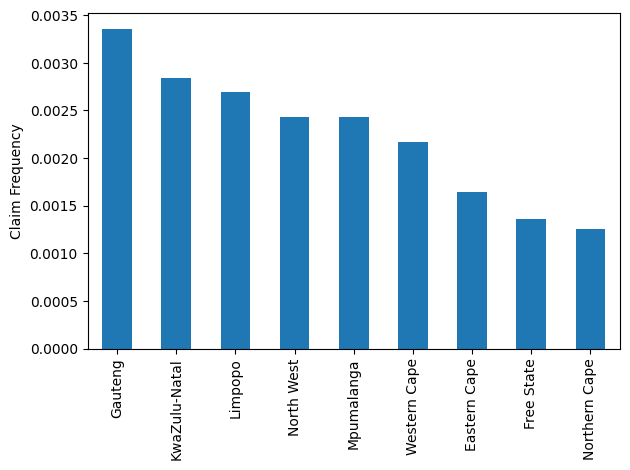

In [25]:
freq_by_prov = cont_df['HasClaim'] / (cont_df['HasClaim'] + cont_df['NoClaim'])
freq_by_prov.sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Claim Frequency')
plt.tight_layout()